## Installations and import

In [28]:
# ! pip install -U sentence-transformers
# ! pip install -U transformers
# ! pip install -U tensorflow
# ! pip install -U xgboost
# ! pip install -U tf-keras


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_org = pd.read_csv("./data/OnlineNewsPopularity.csv")

new_cols = [x.strip() for x in df_org.columns]
df_org.columns = new_cols

### Slicing data to 5000 data points as my local machine is not able to handel all 39644 rows

In [3]:
df = df_org[:5000]

## Part 1: NLP Feature Engineering**

- Extract NLP features from the article heading text (can be seen in the url), such as sentiment scores, topic modeling outputs, and named entity recognition (NER) counts and/or use the data provided.
- Utilize a pre-trained LLM like BERT or GPT-3 to generate embeddings for each article and explore how these embeddings can be used as features.

### Extracting sentiment and embeddings from url

Ideally this should have been done on whole article and leverage a LLM for that but due no article access and LLM access could not do that

In [4]:
df["url_heading"] = df["url"].apply(lambda x: x.split("/")[-2])

In [5]:
df["url_heading"]

0                            amazon-instant-video-browser
1                             ap-samsung-sponsored-tweets
2                          apple-40-billion-app-downloads
3                                astronaut-notre-dame-bcs
4                                        att-u-verse-apps
                              ...                        
4995    late-roger-eberts-final-movie-review-publishes...
4996                                         linkme-wrist
4997                               mad-men-roger-sterling
4998                                    mad-men-supercuts
4999                                   micromanaging-boss
Name: url_heading, Length: 5000, dtype: object

In [6]:
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis")
# model = distilbert/distilbert-base-uncased-finetuned-sst-2-english
# data = ["I love you", "I hate you"]
# sentiment_pipeline(data)


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [7]:

df["url_sentiment"] = df["url_heading"].apply(lambda x: sentiment_pipeline(x)[0]["score"])

In [8]:
df.to_csv("data/temp1.csv", index=False)

In [9]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

# # Sentences we want to encode. Example:
# sentence = ['This framework generates embeddings for each input sentence']

# Sentences are encoded by calling model.encode()
embedding = model.encode(df["url"])

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [10]:
embedding.shape

(5000, 384)

In [11]:
embedding[0].shape


(384,)

In [12]:
embedd = [i for i in embedding]
df["url_embedding"] = embedd


In [13]:
column_name = 'url_embedding'
df_temp = pd.DataFrame(df[column_name].tolist(), index=df.index)
df_temp.columns = [f"{column_name}_{i}" for i in range(df_temp.shape[1])]

# Merge the new DataFrame with the original one
df = pd.concat([df] + [df_temp], axis=1).drop(column_name, axis=1)

In [14]:
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,url_embedding_374,url_embedding_375,url_embedding_376,url_embedding_377,url_embedding_378,url_embedding_379,url_embedding_380,url_embedding_381,url_embedding_382,url_embedding_383
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.043159,-0.015933,0.104369,-0.092404,0.009372,0.106246,0.126272,0.019328,0.045224,0.108116
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.005909,-0.051810,0.055330,-0.051499,-0.030876,-0.010856,0.101063,-0.048387,-0.009653,0.066260
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.020030,-0.013891,0.002440,-0.125997,0.003514,0.058349,0.147462,-0.006330,0.011963,0.077882
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,-0.028995,0.044318,-0.001740,-0.013324,-0.032265,-0.005884,0.021874,0.016938,-0.017774,0.043158
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.076541,-0.040955,0.032634,-0.057821,0.026803,-0.003544,0.109821,-0.019016,0.016319,0.046237


In [16]:
61 + 384 + 2

447

In [17]:
df.to_csv("data/temp2.csv", index=False)


## Part 2: Correlation Analysis**

- Conduct correlation analysis between the engineered NLP features and the article's popularity. Identify which features have the strongest association with higher engagement levels.

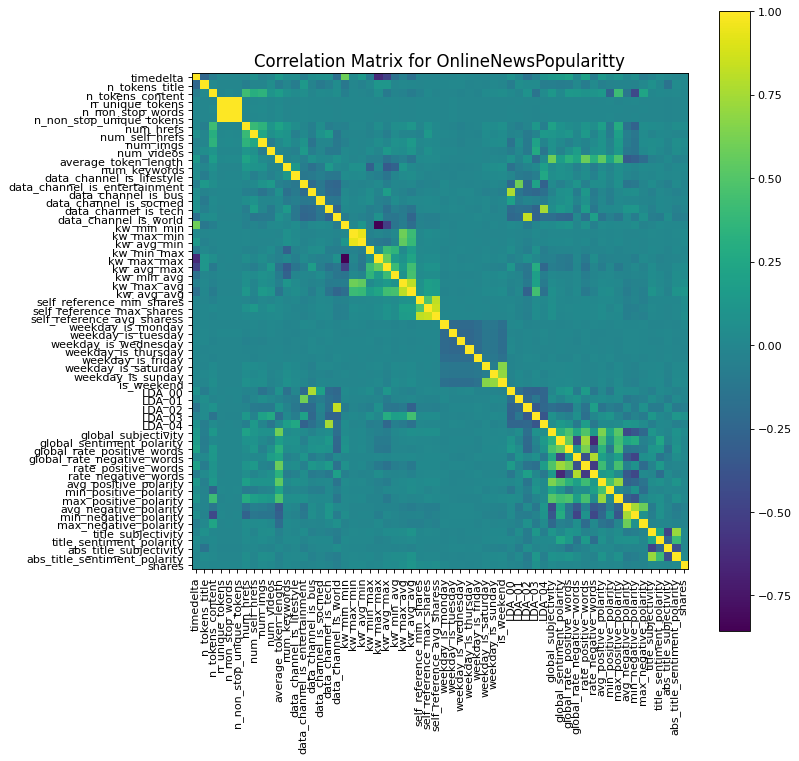

In [19]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = "OnlineNewsPopularitty"
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

plotCorrelationMatrix(df_org, 10)

In [20]:
df_corr = df_org.corr()['shares'].sort_values()


In [21]:
# Lowest correlated feature
df_corr.head(10)

LDA_02                          -0.059163
data_channel_is_world           -0.049497
avg_negative_polarity           -0.032029
average_token_length            -0.022007
max_negative_polarity           -0.019300
min_negative_polarity           -0.019297
data_channel_is_entertainment   -0.017006
LDA_04                          -0.016622
data_channel_is_tech            -0.013253
rate_positive_words             -0.013241
Name: shares, dtype: float64

In [22]:
# Highest correlated feature
df_corr.tail(10)[:-1]


kw_min_avg                    0.039551
kw_avg_max                    0.044686
num_hrefs                     0.045404
self_reference_max_shares     0.047115
self_reference_min_shares     0.055958
self_reference_avg_sharess    0.057789
kw_max_avg                    0.064306
LDA_03                        0.083771
kw_avg_avg                    0.110413
Name: shares, dtype: float64

## Part 3: Predictive Modeling**

- Build predictive models to estimate the popularity of an article based on the features, including the NLP features you've engineered.
- Compare the performance of different models, such as linear regression, random forest, and a neural network approach.

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [25]:
df_ = df.copy()

In [26]:
del df["url"]
del df["url_heading"]


In [27]:
X = df.drop("shares", axis=1).values
y = df["shares"].values

In [28]:
scaler = StandardScaler()

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25)

train_X_scale = scaler.fit_transform(train_X)
test_X_scale = scaler.transform(test_X)

### XGB

In [29]:
from xgboost import XGBRegressor



my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
my_model.fit(train_X, train_y, verbose=False)

# make predictions
predictions = my_model.predict(test_X)

print("Mean Absolute Error : " + str(mean_absolute_error(predictions, test_y)))
print("Mean Squared Error : " + str(mean_squared_error(predictions, test_y)))


Mean Absolute Error : 5063.706380058288
Mean Squared Error : 1198898651.6949232


Further hyperparameter tuning can be done on this.

### Neural Network

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

In [31]:
ann = Sequential()                          # Initializing the ANN
ann.add(Dense(units=60, activation="relu"))  #Adding First Hidden Layer
ann.add(Dense(units=60, activation="relu"))  # Adding Second Hidden Layer
ann.add(Dense(units=1))   # Adding Output Layer

ann.compile(optimizer="adam",loss="mean_squared_error")

ann.fit(x=train_X_scale, y=train_y, epochs=10, batch_size=32,validation_data=(test_X_scale,test_y),callbacks=EarlyStopping(monitor='val_loss',patience=4))

Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 79817368.0000 - val_loss: 77493104.0000
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - loss: 594433664.0000 - val_loss: 73844680.0000
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 153855904.0000 - val_loss: 69635664.0000
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - loss: 85853992.0000 - val_loss: 68594088.0000
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - loss: 311926272.0000 - val_loss: 68524920.0000
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 118788248.0000 - val_loss: 68686136.0000
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - loss: 46571856.0000 - val_loss: 68847680.0000
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - loss: 160940224.0000 - val_loss: 69300304.0000
Epoch 9/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 94137944.0000 - val_loss: 69657496.0000


<Axes: >

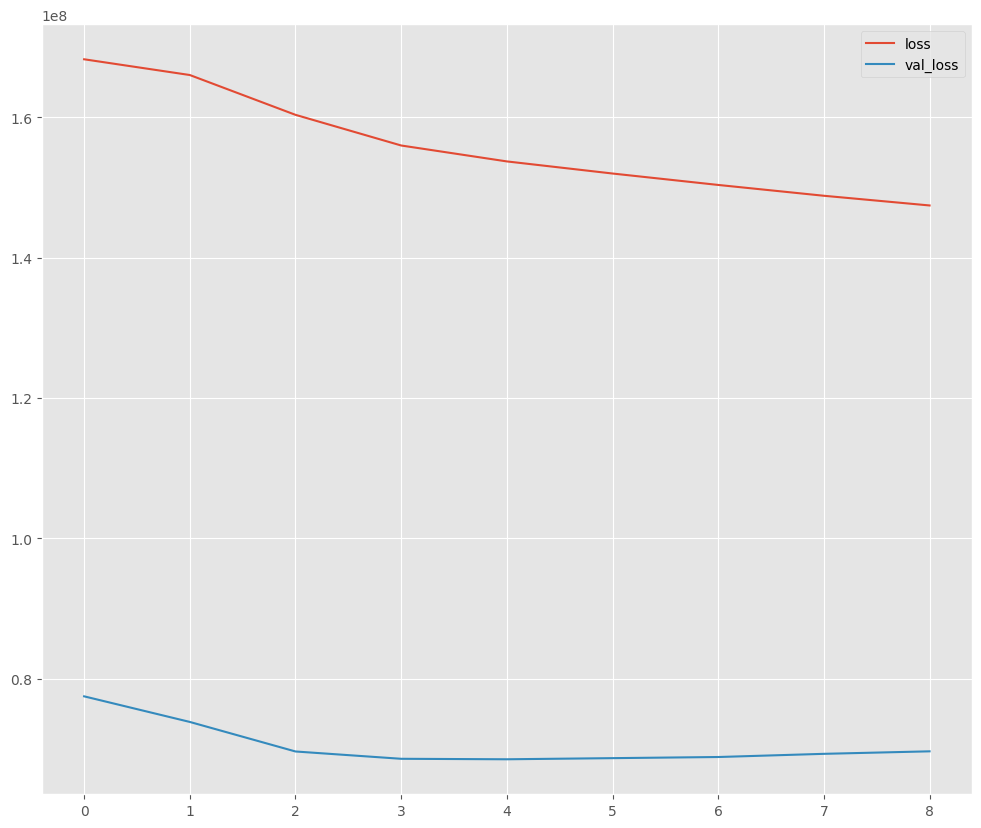

In [32]:
# pd.DataFrame(ann.history.history)
plt.style.use("ggplot")
pd.DataFrame(ann.history.history).plot(figsize=(12,10))

In [33]:
predictions = ann.predict(test_X_scale)

print("MAE:",mean_absolute_error(test_y,predictions))
print ("MSE:",mean_squared_error(test_y,predictions))
print("RMSE:",np.sqrt(mean_squared_error(test_y,predictions)))



40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
MAE: 2979.630471151733
MSE: 69657516.66357845
RMSE: 8346.107875146261


## Part 4: Insight Generation and Recommendation (Optional)**

- Analyze the model to identify key factors that predict higher article engagement.
- Provide recommendations for content creators based on your findings, focusing on aspects likely to increase article popularity.

Two ways we can identify key factors:
- Features with high correlation
- feature with high feature importance in XGB model

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

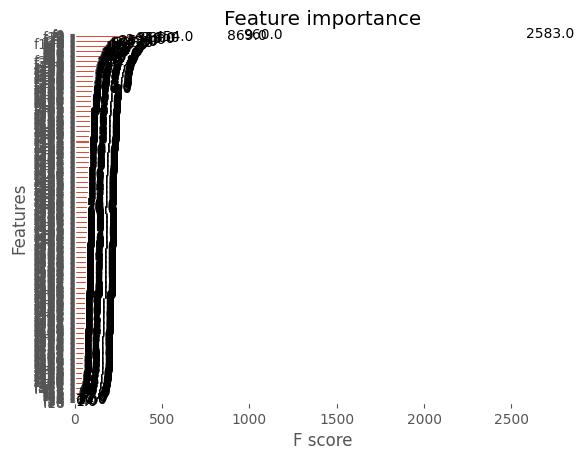

In [43]:
from xgboost import plot_importance
plot_importance(my_model)

In [42]:
print(my_model.feature_importances_)

[4.06464882e-04 4.63163888e-04 3.77784309e-04 2.52071884e-04
 0.00000000e+00 5.54523140e-04 9.95947281e-04 2.44781782e-04
 1.90147420e-03 4.38665092e-01 2.87199160e-04 1.34984861e-04
 2.99070507e-05 3.24062770e-03 5.14014687e-07 8.18002911e-04
 9.79801043e-05 1.56376082e-05 1.82075659e-03 1.73361172e-04
 1.46473249e-04 1.21066594e-04 0.00000000e+00 2.48752389e-04
 1.43668463e-03 6.64011459e-04 6.80428324e-03 1.25033967e-03
 4.21876553e-04 9.27627378e-04 1.08301283e-04 3.31835545e-05
 1.22899393e-04 3.37310885e-05 1.63204153e-04 5.85149229e-03
 5.16365326e-05 1.37675821e-03 1.26185289e-04 4.99953399e-04
 2.06752331e-04 1.20727008e-03 1.04399805e-03 7.48514314e-04
 5.92632859e-04 1.68966071e-04 2.23656869e-04 3.93022456e-05
 1.17937845e-04 7.77791574e-05 1.06487272e-03 3.88504704e-04
 9.84619139e-04 2.50060199e-04 3.38375592e-03 2.97623628e-04
 1.96204195e-03 5.48232783e-05 4.92059451e-04 1.67321449e-03
 2.71868252e-04 1.10151312e-04 3.17893282e-04 2.68807315e-04
 1.15431972e-01 3.799782

In [44]:
df_corr.tail(10)[:-1]

kw_min_avg                    0.039551
kw_avg_max                    0.044686
num_hrefs                     0.045404
self_reference_max_shares     0.047115
self_reference_min_shares     0.055958
self_reference_avg_sharess    0.057789
kw_max_avg                    0.064306
LDA_03                        0.083771
kw_avg_avg                    0.110413
Name: shares, dtype: float64